# Twitter Sentiment Analysis for Stock Investment


**Claire Zhao Sun**
- Matrikelnummer: 3630998
- Msc. Scientific Computing, Heidelberg University
- pz237@stud.uni-heidelberg.de

*Last Modified: 2021.02.04*


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import pickle
import time
import torch
import transformers
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from wordcloud import WordCloud

# Set dataframe display options - displaying all contents in all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

from IPython.display import Markdown


In [12]:
# in case of reloading modules after modification
import sys
import importlib
importlib.reload(sys.modules['modules.preprocessing_SUN'])


C:\Users\clair\Desktop\WS2020\NLP\Project\modules\preprocessing_SUN.py:36: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dict_emoticon = pd.read_csv('./modules/emoticons.csv', header='infer', delimiter='\t', index_col=0).T.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\spacy\util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


<module 'modules.preprocessing_SUN' from 'C:\\Users\\clair\\Desktop\\WS2020\\NLP\\Project\\modules\\preprocessing_SUN.py'>

## 1. Inputs Specification

In [49]:
use_GPU = True

# file paths to saved models
finetuned_save = "models/bertbase_state.bin"
nb_classifier_save = 'models/Count_word_NB_balancedWeight.pickle'
count_vectorizer_save = 'models/CountVectorizer_unigram.pickle'
lr_classifier_save = 'models/Tfidf_word_LR_balancedWeight.pickle'
tfidf_vectorizer_save = 'models/TfidfVectorizer_unigram.pickle'
svm_classifier_save ='models/Word2Vec_news300_aggMean_SVM_balancedWeight.pickle'
w2v_vectorizer_save = 'models/Word2Vec_news300_aggMean.pickle'

# files paths to raw tweets data
path ='C:/Users/clair/Desktop/WS2020/TA/Project/Data/Twitter_Raw/'
files = ['Nikola_20201126_20201203.csv','Nikola_20201203_20201209.csv','Nikola_20201209_20201216.csv','Nikola_20201216_20201223.csv',
'Nikola_20201230_20210105.csv','Nikola_20210105_20210111.csv','Nikola_20210111_20210117.csv','Nikola_20210117_20210124.csv','Nikola_20210124_20210131.csv']
sentiments_save = 'data/Nikola_sentiments.csv'
predictions_save = 'data/Nikola_predictions.csv'
ticker = 'NKLA'

## 2. Set-up Preparation

In [46]:
# set up device
if (use_GPU and torch.cuda.is_available()):
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')
    device = torch.device("cpu")

# load customized functions
from modules.preprocessing_SUN import tweet_preprocessing, tweet_tokenizing, display_stats
from modules.vader_SUN import vader
from modules.ML_classifiers_SUN import ML_classifier_vectorizer
from modules.BERT_finetuning_SUN import TwitterRawDataset, SentimentClassifier_BERT,infer_raw, bert_base
#from modules.ensemble_SUN import Ensemble, Ensemble2

# download pretrained BERT model
pretrained_bert = transformers.BertModel.from_pretrained('bert-base-cased')
tokenizer_bert = transformers.BertTokenizer.from_pretrained('bert-base-cased')

# dictionary to translate sentiments (str) to class labels (int)
sentiment_to_label = {'negative':0,'neutral':1,'positive':2}
sentiments = ['negative','neutral','positive']


Using CPU


## 3. Sentiment Analysis Pipeline
loading raw tweets --> text preprocessing --> sentiment analysis --> prediction aggregation --> visualization  

In [47]:
# load raw tweets - should be tweets on the same stock
print(f'\nLoading raw tweets from {len(files)} files:')
df = pd.DataFrame(columns=['DateTime', 'Text','ID'])
start_time = time.time()
for file in files:
    df_ = pd.read_csv(path+file,na_filter=False, header=None).iloc[:,0:3]
    df_.columns=['DateTime', 'Text','ID']
    df = df.append(df_)
print(f'>> loading: {time.time()-start_time:.3f} s')

# remove duplicated tweets (due to downloads on overlapping days)
df.drop_duplicates(subset='ID',inplace=True) #len(df)


# text preprocessing
print(f'\nStart processing {len(df)} raw tweets:')
start_time = time.time()
df['date'] = pd.to_datetime(df['DateTime']).dt.date
df['text_unicode'] = df['Text'].apply(lambda x: ast.literal_eval(x).decode('utf-8'))
df['text_clean'] = df['text_unicode'].apply(tweet_preprocessing)
df['token_lens']=df['text_clean'].apply(tweet_tokenizing, args=(False,False)).apply(len) #no stemming and no stopwords removal
print(f'>> text preprocessing: {time.time()-start_time:.3f} s')

# remove columns no longer needed and reset index
df.drop(['DateTime','Text','ID'],axis = 1, inplace = True)
df = df.reset_index(drop=True)


# sentiments prediction - comparing speed of different models
print(f'\nStart sentiment analysis on {len(df)} tweets:')

start_time = time.time()
df['vader'] = df['text_clean'].apply(vader)
print(f'>> vader: {time.time() - start_time:.3f} s')

start_time = time.time()
df['nb_count'] = ML_classifier_vectorizer(df['text_clean'],nb_classifier_save, count_vectorizer_save)
print(f'>> nb_count: {time.time() - start_time:.3f} s')

start_time = time.time()
df['lr_tfidf'] = ML_classifier_vectorizer(df['text_clean'],lr_classifier_save, tfidf_vectorizer_save)
print(f'>> lr_tfidf: {time.time() - start_time:.3f} s')

start_time = time.time()
df['svm_w2v'] = ML_classifier_vectorizer(df['text_clean'],svm_classifier_save, w2v_vectorizer_save)
print(f'>> svm_w2v: {time.time() - start_time:.3f} s')

start_time = time.time()
df['bert_base'] = bert_base(df['text_clean'],pretrained_bert,tokenizer_bert,finetuned_save,device,batch_size=256) #len(df): CUDA out of memory 5.35G
print(f'>> bert: {time.time() - start_time:.3f} s')

start_time = time.time()
df['majority'] = df[['bert_base','vader','nb_count','lr_tfidf','svm_w2v']].mode(axis=1)[0].astype(int)
print(f'>> majority: {time.time() - start_time:.3f} s')

# separate daily predictions
df_summary = pd.get_dummies(df, columns=['majority']).groupby('date').sum()

print("\nSentiment analysis completed!")

Loading raw tweets from 2 files:
>> loading: 0.100 s
Start processing 18683 raw tweets:
>> text preprocessing: 23.221 s
Start sentiment analysis on 18683 tweets:
>> vader: 1.999 s
>> nb_count: 0.316 s
>> lr_tfidf: 0.314 s
>> svm_w2v: 19.500 s
>> bert: 1747.615 s
>> majority: 5.488 s


### Data Visualisation

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


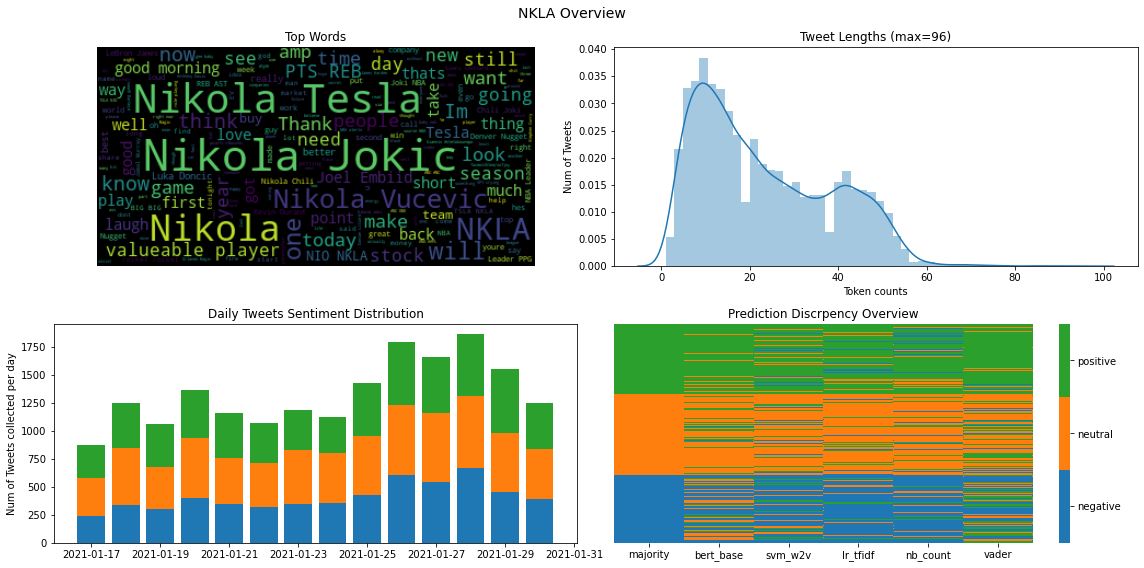

In [53]:
fig, ax = plt.subplots(2,2,figsize=(16,8),tight_layout=True)
fig.suptitle(f"{tiker} Overview", fontsize=14)

# word cloud
text = df['text_clean'].to_string().replace('USERNAME','')
wordcloud = WordCloud(max_font_size=40).generate(text)
ax[0,0].imshow(wordcloud, interpolation='bilinear')
ax[0,0].axis("off");
ax[0,0].set_title('Top Words')

# Distribution of token lengths per tweet
ax01 = sns.distplot(df['token_lens'],ax=ax[0,1])
ax01.set_xlabel('Token counts')
ax01.set_ylabel('Num of Tweets')
ax01.set_title('Tweet Lengths (max={})'.format(df['token_lens'].max()))

# Daily Tweets sentiment distribution
ind = df_summary.index
cmap = sns.color_palette("tab10", 3) # same color scheme as default matplotlib
ax[1,0].bar(ind, df_summary['majority_0'])
ax[1,0].bar(ind, df_summary['majority_1'], bottom=df_summary['majority_0'])
ax[1,0].bar(ind, df_summary['majority_2'], bottom=df_summary['majority_0']+df_summary['majority_1'])
ax[1,0].set_title('Daily Tweets Sentiment Distribution')
ax[1,0].set_ylabel('Num of Tweets collected per day')

# Prediction comparison by different models
selected = ['majority','bert_base','svm_w2v','lr_tfidf','nb_count','vader']
ax11 = sns.heatmap(df[selected].sort_values(by='majority',ascending=False), cmap=cmap, yticklabels=False, ax=ax[1,1])
ax11.set_title('Prediction Discrpency Overview')
colorbar = ax11.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r/3*(0.5+i) for i in range(3)])
colorbar.set_ticklabels(sentiments)


### Saving results

In [54]:
df[['date','text_unicode','token_lens']+selected].to_csv(predictions_save,index=False)
df_summary.to_csv(sentiments_save,index=False)

### Reload Results


# 

## 4. Share Price Prediction Pipeline